# SEA 820 Final Project: Detecting AI-Generated Text
**Authors**: Bhavjot Kaur Pal and Samay Sehgal

**Date**: 08/08/2025



Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import os
import torch
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
import re
from google.colab import drive

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

 Load and Preprocess Data

In [2]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/NLP_Final_project/data/AI_Human.csv'

try:
    df = pd.read_csv(DATA_PATH)
    df.rename(columns={'generated': 'label'}, inplace=True)
    print("DataFrame loaded and renamed successfully.")
except FileNotFoundError:
    print(f"ERROR: Dataset '{DATA_PATH}' not found.")
    exit()

print(df.head())
df.info()
print(df['label'].value_counts())

def preprocess_text_classic(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

df['preprocessed_text_classic'] = df['text'].apply(preprocess_text_classic)

Mounted at /content/drive
DataFrame loaded and renamed successfully.
                                                text  label
0  Cars. Cars have been around since they became ...    0.0
1  Transportation is a large necessity in most co...    0.0
2  "America's love affair with it's vehicles seem...    0.0
3  How often do you ride in a car? Do you drive a...    0.0
4  Cars are a wonderful thing. They are perhaps o...    0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    487235 non-null  object 
 1   label   487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB
label
0.0    305797
1.0    181438
Name: count, dtype: int64


Classic ML Models

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['preprocessed_text_classic'], df['label'], test_size=0.2, random_state=SEED, stratify=df['label']
)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(random_state=SEED, solver='liblinear')
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tfidf)
baseline_accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
baseline_f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)
baseline_accuracy_nb = accuracy_score(y_test, y_pred_nb)
baseline_f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

# Support Vector Machine
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

# Print individual model results
print("Logistic Regression Accuracy:", baseline_accuracy_log_reg)
print("Naive Bayes Accuracy:", baseline_accuracy_nb)
print("SVM Accuracy:", svm_accuracy)

# Identify best baseline
best_baseline_accuracy = max(baseline_accuracy_log_reg, baseline_accuracy_nb, svm_accuracy)
best_baseline_f1 = max(baseline_f1_log_reg, baseline_f1_nb, svm_f1)

print("\nBest Baseline Model for Final Comparison:")
print(f"Accuracy: {best_baseline_accuracy:.4f}, F1-Score: {best_baseline_f1:.4f}")

Logistic Regression Accuracy: 0.6287623015587961
Naive Bayes Accuracy: 0.6287725635473642
SVM Accuracy: 0.6287725635473642

Best Baseline Model for Final Comparison:
Accuracy: 0.6288, F1-Score: 0.4867


Fine-Tuning DistilBERT with LoRA

In [7]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_lora = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

TRANSFORMER_DATA_SAMPLE_SIZE = 50000
if len(df) > TRANSFORMER_DATA_SAMPLE_SIZE:
    df_sampled = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), TRANSFORMER_DATA_SAMPLE_SIZE // 2), random_state=SEED)
    ).reset_index(drop=True)
else:
    df_sampled = df

hf_dataset = Dataset.from_pandas(df_sampled[['text', 'label']])
hf_dataset = hf_dataset.cast_column('label', ClassLabel(num_classes=2, names=['human', 'AI-generated']))

split = hf_dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column="label")
val_test_split = split['test'].train_test_split(test_size=0.5, seed=SEED, stratify_by_column="label")

train_dataset_hf = split['train']
val_dataset_hf = val_test_split['train']
test_dataset_hf = val_test_split['test']

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train_dataset = train_dataset_hf.map(tokenize_function, batched=True).remove_columns(["text"])
tokenized_val_dataset = val_dataset_hf.map(tokenize_function, batched=True).remove_columns(["text"])
tokenized_test_dataset = test_dataset_hf.map(tokenize_function, batched=True).remove_columns(["text"])

for ds in [tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset]:
    ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model_lora = get_peft_model(model_lora, lora_config)

training_args_lora = TrainingArguments(
    output_dir="./results_lora_finetune",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_dir="./logs_lora_finetune",
    logging_steps=50,
    seed=SEED,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
    }

trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics
)

trainer_lora.train()
print("\n--- 2.3 Evaluating PEFT/LoRA Fine-tuned Model on Test Set ---")
metrics_lora_finetune = trainer_lora.evaluate(tokenized_test_dataset)
print("PEFT/LoRA Fine-tune Test Set Metrics:", metrics_lora_finetune)

print(f"\n--- Performance Comparison: Best Baseline vs. PEFT/LoRA Fine-tune ---")
print(f"Best Baseline Accuracy: {best_baseline_accuracy:.4f}")
print(f"PEFT/LoRA Fine-tune Accuracy: {metrics_lora_finetune['eval_accuracy']:.4f}")
print(f"Best Baseline F1-Score: {best_baseline_f1:.4f}")
print(f"PEFT/LoRA Fine-tune F1-Score: {metrics_lora_finetune['eval_f1']:.4f}")
print(f"PEFT/LoRA Fine-tune Precision: {metrics_lora_finetune['eval_precision']:.4f}")
print(f"PEFT/LoRA Fine-tune Recall: {metrics_lora_finetune['eval_recall']:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3923457868.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('label', group_keys=False).apply(


Casting the dataset:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.166700,0.187511,0.930000,0.929911,0.932191,0.930000
2,0.143200,0.164257,0.942200,0.942116,0.944796,0.942200
3,0.127100,0.139941,0.950400,0.950362,0.951777,0.950400



--- 2.3 Evaluating PEFT/LoRA Fine-tuned Model on Test Set ---


PEFT/LoRA Fine-tune Test Set Metrics: {'eval_loss': 0.1359221488237381, 'eval_accuracy': 0.9476, 'eval_f1': 0.94756670275892, 'eval_precision': 0.9487398710708996, 'eval_recall': 0.9476, 'eval_runtime': 18.0633, 'eval_samples_per_second': 276.804, 'eval_steps_per_second': 17.328, 'epoch': 3.0}

--- Performance Comparison: Best Baseline vs. PEFT/LoRA Fine-tune ---
Best Baseline Accuracy: 0.6288
PEFT/LoRA Fine-tune Accuracy: 0.9476
Best Baseline F1-Score: 0.4867
PEFT/LoRA Fine-tune F1-Score: 0.9476
PEFT/LoRA Fine-tune Precision: 0.9487
PEFT/LoRA Fine-tune Recall: 0.9476


Confidence Histogram & Misclassifications


Total misclassified examples in the test set: 262

--- Sample Misclassified Texts for Manual Review ---

--- Misclassified Example 1 ---
Text (first 300 chars):  Students are expected to identify a career BV the time the enter high school. However, it is not a good idea for students to commit to a specific career at a young age because it will cause distractions from school work, students are still getting education, and specific jobs will distract students...
True Label: AI-generated
Predicted Label: Human-written
Confidence in incorrect prediction: 0.9825
----------------------------------------

--- Misclassified Example 2 ---
Text (first 300 chars): In "The Challenge of Exploring Venus," the author gives readers details on how Venus is Earth's "twin." Venus is the closest planet to Earth in both side and distance. The author discusses with readers why scientist want to explore Venus and how they are taking the steps to take it. The author of "T...
True Label: Human-written
Predict

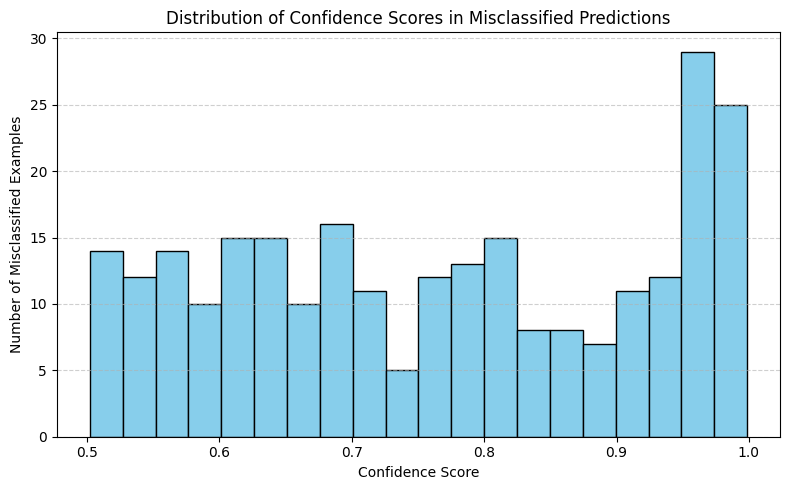

In [9]:
predictions_output = trainer_lora.predict(tokenized_test_dataset)
test_preds = np.argmax(predictions_output.predictions, axis=1)
test_labels_true = predictions_output.label_ids
test_probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions_output.predictions), dim=-1).numpy()

misclassified_indices = np.where(test_preds != test_labels_true)[0]
print(f"\nTotal misclassified examples in the test set: {len(misclassified_indices)}")

misclassified_texts = test_dataset_hf.select(misclassified_indices)['text']
misclassified_true_labels = test_labels_true[misclassified_indices]
misclassified_predicted_labels = test_preds[misclassified_indices]
misclassified_probabilities = test_probabilities[misclassified_indices]

print("\n--- Sample Misclassified Texts for Manual Review ---")
for i in range(min(5, len(misclassified_indices))):
    true_label_str = 'AI-generated' if misclassified_true_labels[i] == 1 else 'Human-written'
    predicted_label_str = 'AI-generated' if misclassified_predicted_labels[i] == 1 else 'Human-written'
    print(f"\n--- Misclassified Example {i+1} ---")
    print(f"Text (first 300 chars): {misclassified_texts[i][:300]}...")
    print(f"True Label: {true_label_str}")
    print(f"Predicted Label: {predicted_label_str}")
    print(f"Confidence in incorrect prediction: {misclassified_probabilities[i][misclassified_predicted_labels[i]]:.4f}")
    print("-" * 40)

#Confidence scores for misclassified predictions
conf_scores = [prob[pred] for prob, pred in zip(misclassified_probabilities, misclassified_predicted_labels)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(conf_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Confidence Score")
plt.ylabel("Number of Misclassified Examples")
plt.title("Distribution of Confidence Scores in Misclassified Predictions")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

